# Stock market forecasting using Time Series analysis With ARIMA model


Time-series forecasting models are the models that are capable to predict future values based on previously observed values. Time-series forecasting is widely used for non-stationary data. Non-stationary data are called the data whose statistical properties e.g. the mean and standard deviation are not constant over time but instead, these metrics vary over time.
These non-stationary input data (used as input to these models) are usually called time-series. Some examples of time-series include the temperature values over time, stock price over time, price of a house over time etc. So, the input is a signal (time-series) that is defined by observations taken sequentially in time.
A time series is a sequence of observations taken sequentially in time.

We will use the ARIMA model to forecast the stock price of TESLA.

__The AutoRegressive Integrated Moving Average (ARIMA) model__
A famous and widely used forecasting method for time-series prediction is the AutoRegressive Integrated Moving Average (ARIMA) model. ARIMA models are capable of capturing a suite of different standard temporal structures in time-series data.
Terminology


__AR__ :Auto Regressive means that the model uses the dependent relationship between an observation and some predefined number of lagged observations (also known as “time lag” or “lag”).


__I__ : Integrated  means that the model employs differencing of raw observations (e.g. it subtracts an observation from an observation at the previous time step) in order to make the time-series stationary.MA:


__MA__:Moving Average  means that the model exploits the relationship between the residual error and the observations.

# Load required libraries

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('TSLA.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000
...,...,...,...,...,...,...
2020-07-02,244.296005,245.600006,237.119995,241.731995,241.731995,86250500
2020-07-06,255.337997,275.558014,253.207993,274.316010,274.316010,102849500
2020-07-07,281.002014,285.899994,267.342010,277.971985,277.971985,107448500


__Visualize the stock’s daily closing price__

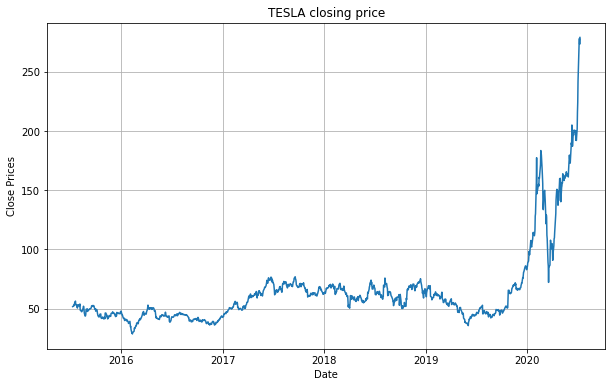

In [3]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('TESLA closing price')
plt.show()

__We can also use a probability distribution to visualize the data in our series__

<AxesSubplot:ylabel='Density'>

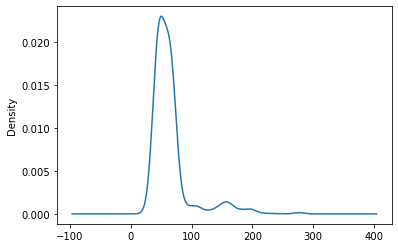

In [4]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

A time series is also regarded to include three systematic components: level, trend, and seasonality, as well as one non-systematic component termed noise.
The average value in the series is called the level.
The increasing or falling value in the series is referred to as the trend.
Seasonality is the series’ recurring short-term cycle.
The random variance in the series is referred to as noise.

__Because time series analysis only works with stationary data, we must first determine whether a series is stationary__

__ADF (Augmented Dickey-Fuller) Test__:
One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.
If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

__The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance)__

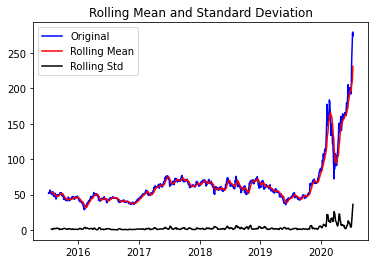

Results of dickey fuller test
Test Statistics                   3.980002
p-value                           1.000000
No. of lags used                 23.000000
Number of observations used    1235.000000
critical value (1%)              -3.435656
critical value (5%)              -2.863883
critical value (10%)             -2.568018
dtype: float64


In [5]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

The increasing mean and standard deviation may be seen in the graph above, indicating that our series isn’t stationary.

We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

Let’s isolate the time series from the Trend and Seasonality.

<Figure size 432x288 with 0 Axes>

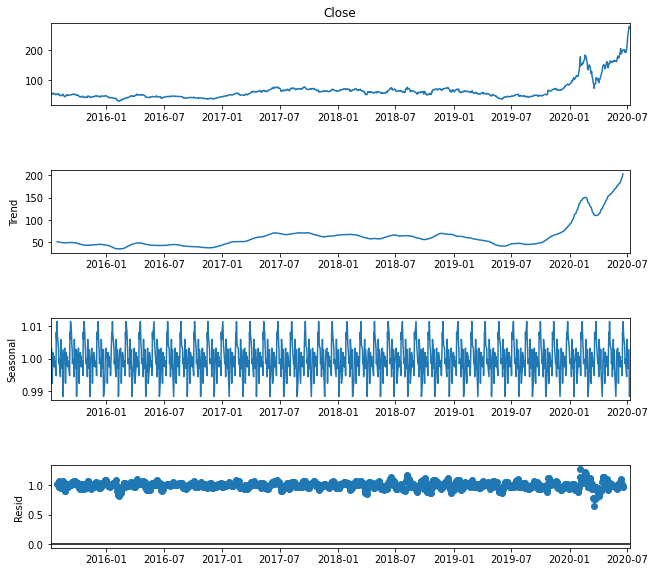

In [6]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 9)

To reduce the magnitude of the values and the growing trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

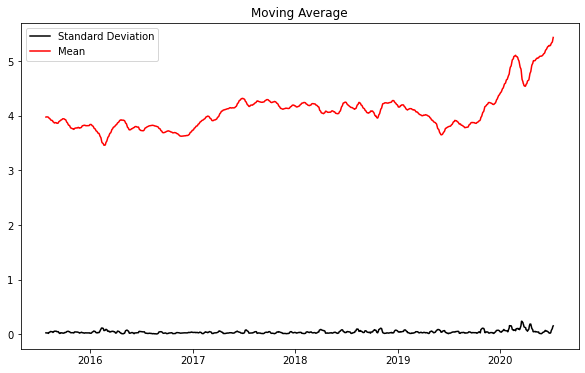

In [7]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

__Now we’ll develop an ARIMA model and train it using the stock’s closing price from the train data. So, let’s visualize the data by dividing it into training and test sets.__

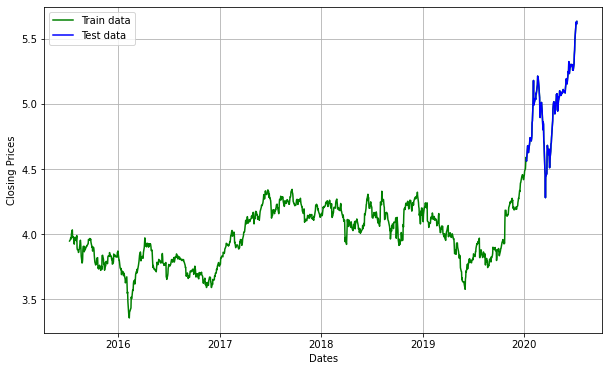

In [8]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

It’s time to choose the ARIMA model’s p,q, and d parameters. We chose the values of p,d, and q last time by looking at the ACF and PACF charts, but this time we’ll utilize Auto ARIMA to find the best parameters without looking at the ACF and PACF graphs.

__Auto ARIMA: Automatically discover the optimal order for an ARIMA model__
The auto_arima function returns a fitted ARIMA model after determining the most optimal parameters for an ARIMA model. This function is based on the forecast::auto. 

The auro_arima function works by performing differencing tests (e.g., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller, or Phillips–Perron) to determine the order of differencing, d, and then fitting models within start p, max p, start q, max q ranges. After conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D, auto_arima also seeks to identify the optimal P and Q hyper-parameters if the seasonal option is enabled.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4784.376, Time=2.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4782.386, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4782.385, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4785.964, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4780.448, Time=0.45 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.590 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1130
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2393.982
Date:                Sat, 28 Aug 2021   AIC                          -4785.964
Time:                        17:28:57   BIC                          -4780.935
Sample:                             0   HQIC                         -4784.064
                               - 1130                                  

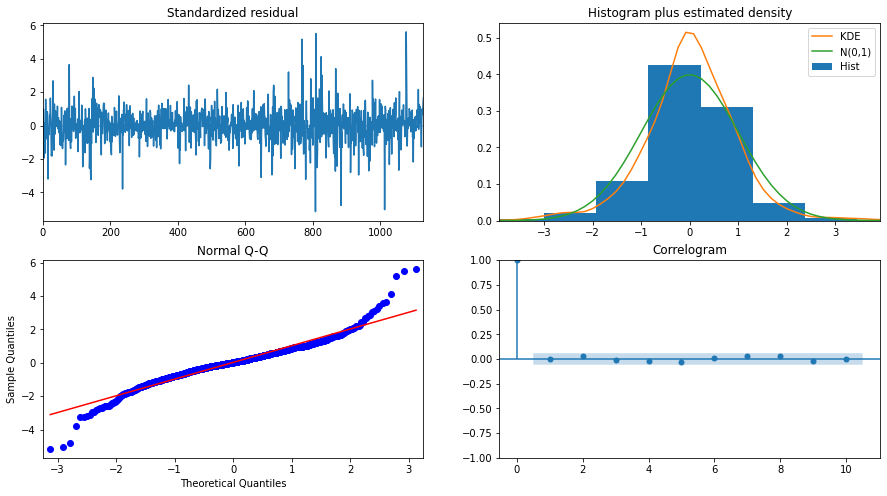

In [9]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Top left: The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

Top Right: The density plot on the top right suggests a normal distribution with a mean of zero.

Bottom left: The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

Bottom Right: The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

__As a result, the Auto ARIMA model assigned the values 1, 1, and 2 to, p, d, and q, respectively.__

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1129
Model:                 ARIMA(1, 1, 2)   Log Likelihood                2394.786
Method:                       css-mle   S.D. of innovations              0.029
Date:                Sat, 28 Aug 2021   AIC                          -4779.573
Time:                        17:29:00   BIC                          -4754.427
Sample:                             1   HQIC                         -4770.072
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.001      0.627      0.531      -0.001       0.002
ar.L1.D.Close    -0.1850      0.815     -0.227      0.820      -1.782       1.412
ma.L1.D.Close     0.1883      0.814     

Let’s now begin forecasting stock prices on the test dataset with a 95% confidence level.

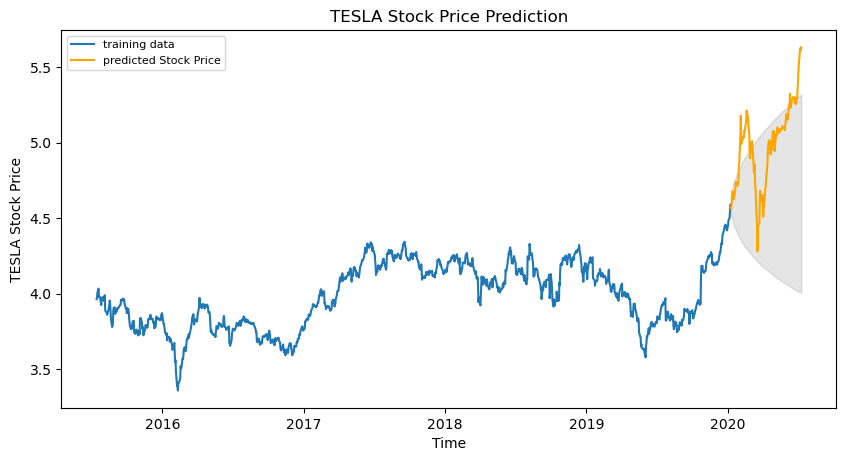

In [12]:
# Forecast
fc, se, conf = fitted.forecast(126, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'orange', label='predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Our model played great.

__The most common accuracy metrics for evaluating forecast results__

In [13]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.19347122324962315
MAE: 0.3770811857788865
RMSE: 0.43985363844081493
MAPE: 0.07356380278587513


__With a MAPE of around 7.3%, the model is 98.5% accurate in predicting the next 30 observations.__